## OVERVIEW
In Jigsaw's fourth Kaggle competition, we return to the Wikipedia Talk page comments featured in our first Kaggle competition. When we ask human judges to look at individual comments, without any context, to decide which ones are toxic and which ones are innocuous, it is rarely an easy task. In addition, each individual may have their own bar for toxicity. We've tried to work around this by aggregating the decisions with a majority vote. But many researchers have rightly pointed out that this discards meaningful information.

😄 🙂 😐 😕 😞
A much easier task is to ask individuals which of two comments they find more toxic. But if both comments are non-toxic, people will often select randomly. When one comment is obviously the correct choice, the inter-annotator agreement results are much higher.

In this competition, we will be asking you to score a set of about fourteen thousand comments. Pairs of comments were presented to expert raters, who marked one of two comments more harmful — each according to their own notion of toxicity. In this contest, when you provide scores for comments, they will be compared with several hundred thousand rankings. Your average agreement with the raters will determine your individual score. In this way, we hope to focus on ranking the severity of comment toxicity from innocuous to outrageous, where the middle matters as much as the extremes.

Can you build a model that produces scores that rank each pair of comments the same way as our professional raters?

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

Related Work
The paper "Ruddit: Norms of Offensiveness for English Reddit Comments" by Hada et al. introduced a similar dataset that involved tuples of four sentences that were marked with best-worst scoring, and this data may be directly useful for building models.

We also note "Constructing Interval Variables via Faceted Rasch Measurement and Multitask Deep Learning: a Hate Speech Application" by Kennedy et al. which compares a variety of different rating schemes and argues that binary classification as typically done in NLP tasks discards valuable information. Combining data from multiple sources, even with different annotation guidelines, may be essential for success in this competition.

Resources
The English language resources from our first Kaggle competition, and our second Kaggle competition, which are both available in the TensorFlow datasets Wikipedia Toxicity Subtypes and Civil Comments can be used to build models.

One example of a starting point is the open source UnitaryAI model.

Google Jigsaw
Google's Jigsaw team explores threats to open societies and builds technology that inspires scalable solutions. One Jigsaw product is PerspectiveAPI which is used by publishers and platforms worldwide as part of their overall moderation strategy.



#### IMPORT NECESSARY PACKAGES

In [1]:
#import warning
import warnings
warnings.filterwarnings('ignore')

#import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

#### IMPORT DATASET

In [2]:
comments_to_score = pd.read_csv('./Dataset/jigsaw-toxic-severity-rating/comments_to_score.csv')
sample_submission = pd.read_csv('./Dataset/jigsaw-toxic-severity-rating/sample_submission.csv')
train = pd.read_csv('./Dataset/jigsaw-toxic-severity-rating/train.csv')

#### DATASET CHECKING

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
comments_to_score.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [5]:
sample_submission.head()

,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


#### DATASET SUMMARY

In [6]:
#simple summary
def simple_eda(df):
    print("summary")
    print("------------------------------")
    print(df.describe())
    print("------------------------------")
    print("columns types")
    print(df.dtypes)
    print("------------------------------")
    print("missing values")
    print(df.isna().sum())
    print("------------------------------")
    print("duplicated values")
    print(df.duplicated().any())
    print("------------------------------")
    print("shape")
    print(df.shape)

In [7]:
simple_eda(train)

summary
------------------------------
               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [8]:
simple_eda(comments_to_score)

summary
------------------------------
         comment_id
count  7.537000e+03
mean   2.235192e+08
std    1.388817e+08
min    1.148900e+05
25%    9.857662e+07
50%    2.093147e+08
75%    3.328366e+08
max    5.045982e+08
------------------------------
columns types
comment_id     int64
text          object
dtype: object
------------------------------
missing values
comment_id    0
text          0
dtype: int64
------------------------------
duplicated values
False
------------------------------
shape
(7537, 2)


#### EDITING TRAIN DATA

In [9]:
#column to be combined
combined_col = ["toxic", "severe_toxic", "obscene", 
                "threat", "insult", "identity_hate"]

#make new column that sums all numerical column in train
train["y"] = train[combined_col].sum(axis=1) > 0

#dropping column
train.drop(combined_col, inplace=True, axis=1)

train

,id,comment_text,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",False
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,False
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",False
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,False


False    143346
True      16225
Name: y, dtype: int64


Text(0.5, 1.0, 'y distribution')

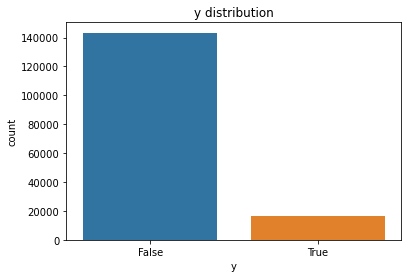

In [10]:
#checking y column distribution
print(train["y"].value_counts())

#plot
sns.countplot(train["y"])
plt.title("y distribution")

In [11]:
#balancing y column
train_balanced = pd.concat([train[train["y"] != 0],
                          train[train["y"] == 0].sample(train[train["y"] != 0].shape[0])])

train_balanced.head()

,id,comment_text,y
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True


True     16225
False    16225
Name: y, dtype: int64


Text(0.5, 1.0, 'y distribution')

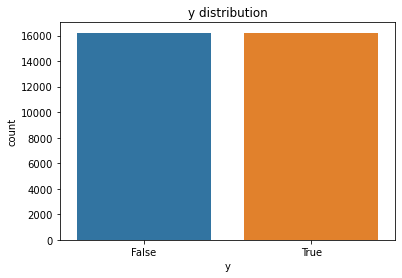

In [12]:
#checking y column distribuion on train_balanced
print(train_balanced["y"].value_counts())

#plot
sns.countplot(train_balanced["y"])
plt.title("y distribution")

#### FEATURE ENGINEERING

In [13]:
#english stopwords
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_eng = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\Arkaan
[nltk_data]     Ah'naf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def feature_engineering(df):
    
    #counting word
    df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))
    
    #counting unique word
    df['unique_word_count'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))
    
    #counting stopwords
    df['stop_word_count'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_eng]))
    
    #counting punctuation
    df['punctuation_count'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    #counting mean word length
    df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    
    return df.head()

In [15]:
feature_engineering(train_balanced)

,id,comment_text,y,word_count,unique_word_count,stop_word_count,punctuation_count,mean_word_length
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True,8,8,4,0,4.625000
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,True,53,50,22,24,5.018868
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",True,10,10,3,5,4.600000
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,True,117,88,53,28,4.478632
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",True,8,8,3,2,4.125000


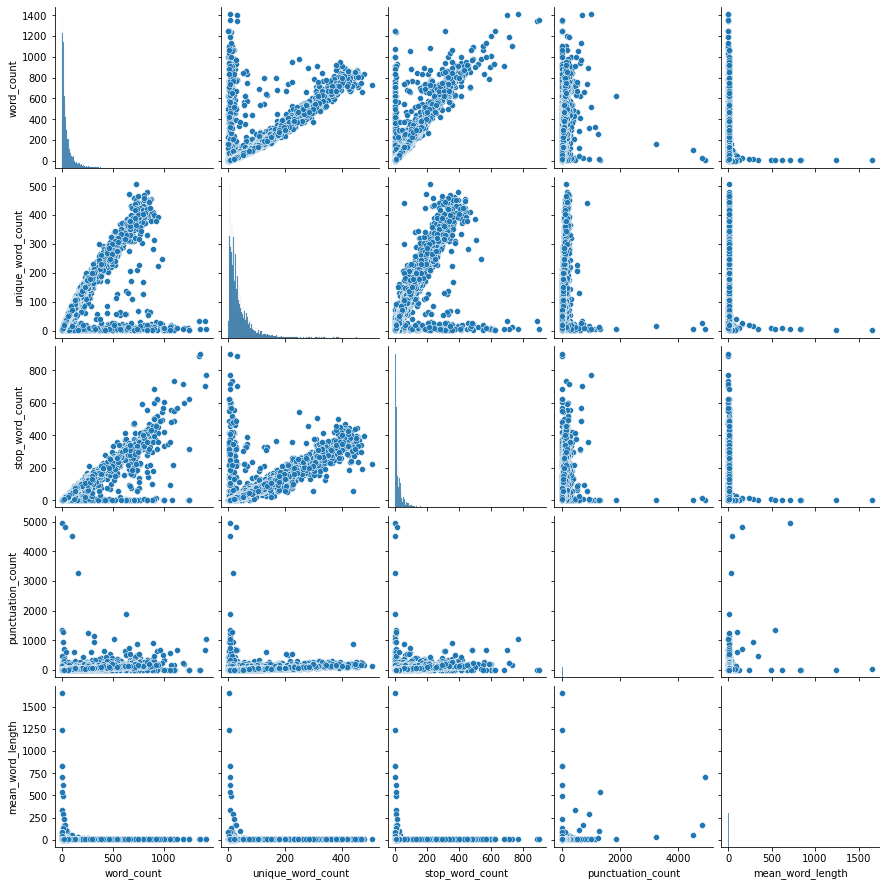

In [16]:
#pair plot of new column
column_pair = ['word_count','unique_word_count','stop_word_count',
               'punctuation_count','mean_word_length']

sns.pairplot(train_balanced[column_pair])

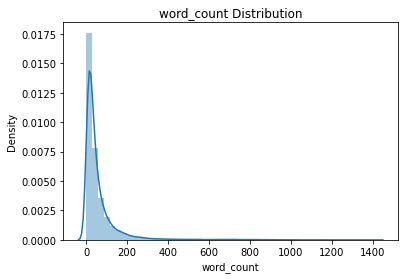

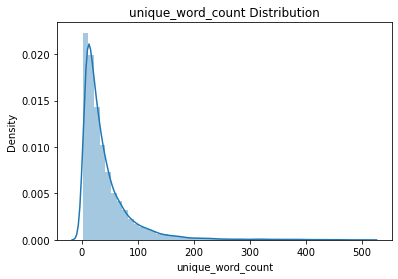

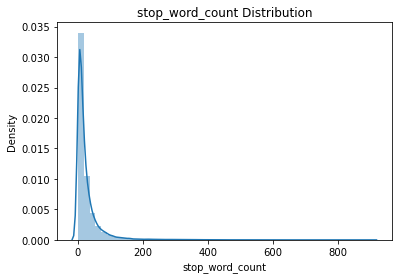

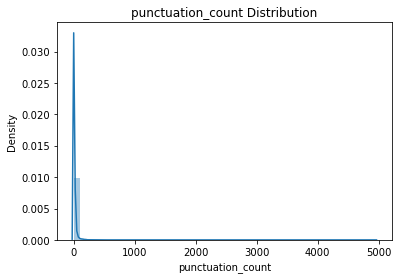

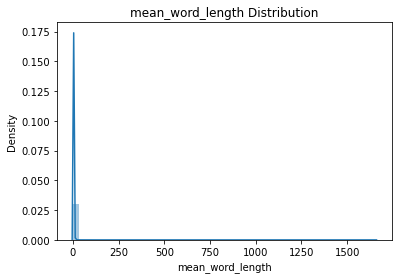

In [17]:
#congestion based on direction
for col in column_pair:
    sns.distplot(train_balanced[col])
    plt.title(col +" Distribution")
    plt.show()

In [18]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


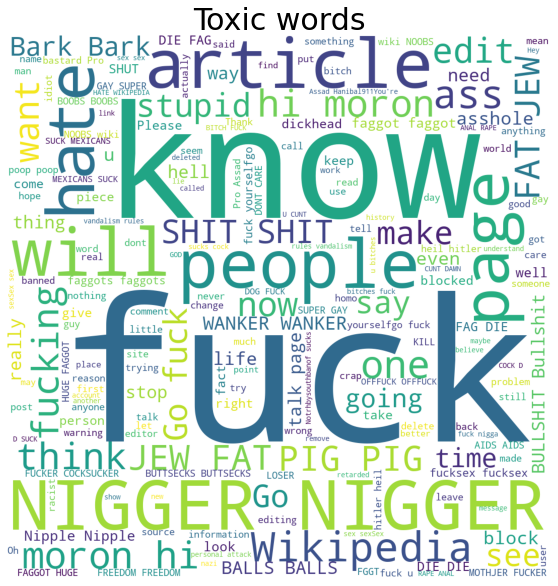

In [19]:
#most toxic word

#import wordcloud
from wordcloud import WordCloud

#querying toxic rows
toxic = train[train['y'] == True]

#plotting
wordcloud_toxic = WordCloud(width=1080, 
                      height=1080, 
                      background_color='white').generate(' '.join(toxic.comment_text.tolist()))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud_toxic)
plt.axis('off')
plt.title('Toxic words', fontsize=30)
plt.show()

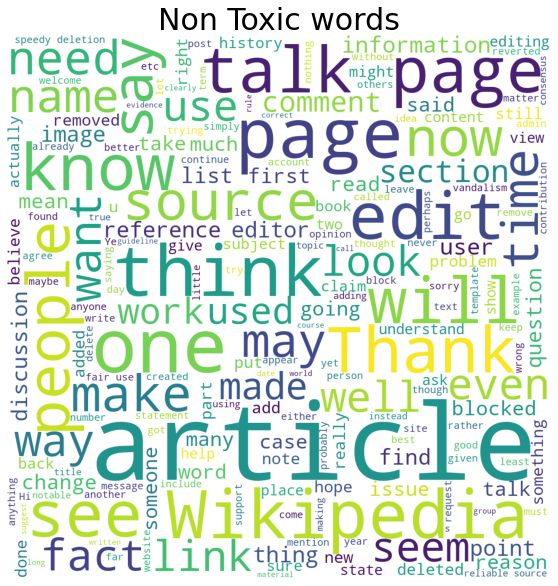

In [20]:
#normal words

#querying toxic rows
non_toxic = train[train['y'] == False]

#plotting
wordcloud_nontoxic = WordCloud(width=1080, 
                      height=1080, 
                      background_color='white').generate(' '.join(non_toxic.comment_text.tolist()))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud_nontoxic)
plt.axis('off')
plt.title('Non Toxic words', fontsize=30)
plt.show()

In [21]:
simple_eda(train_balanced)

summary
------------------------------
         word_count  unique_word_count  stop_word_count  punctuation_count  \
count  32450.000000       32450.000000     32450.000000       32450.000000   
mean      61.329522          41.784376        26.922928          15.396394   
std      103.290609          49.627972        45.973839          61.101196   
min        1.000000           1.000000         0.000000           0.000000   
25%       14.000000          13.000000         5.000000           3.000000   
50%       30.000000          26.000000        13.000000           7.000000   
75%       65.000000          51.000000        30.000000          15.000000   
max     1411.000000         508.000000       902.000000        4942.000000   

       mean_word_length  
count      32450.000000  
mean           5.039004  
std           15.141654  
min            1.000000  
25%            4.213766  
50%            4.603662  
75%            5.022222  
max         1655.000000  
------------------------

#### TEXT PROCESSING

In [22]:
#remove non alphabets
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#remove punctuations
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x: re.sub('[<>=,\.!?:()"]', '', x))

#remove html tag (<.....>)
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x: re.sub('<.*?>', ' ', x))
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x: re.sub('br', ' ', x))

#lower case
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x: x.lower())

#remove stop words
train_balanced['comment_text'] = train_balanced['comment_text'].apply(lambda x : [i for i in x.split() if i not in stop_eng])

train_balanced.head()

,id,comment_text,y,word_count,unique_word_count,stop_word_count,punctuation_count,mean_word_length
6,0002bcb3da6cb337,"[cocksucker, piss, around, work]",True,8,8,4,0,4.625000
12,0005c987bdfc9d4b,"[hey, talk, exclusive, group, wp, talibans, go...",True,53,50,22,24,5.018868
16,0007e25b2121310b,"[bye, look, come, think, comming, back, tosser]",True,10,10,3,5,4.600000
42,001810bf8c45bf5f,"[gay, antisemmitian, archangel, white, tiger, ...",True,117,88,53,28,4.478632
43,00190820581d90ce,"[fuck, filthy, mother, ass, dry]",True,8,8,3,2,4.125000


#### DATA SPLITTING

In [23]:
X = train_balanced.drop(columns=["y"], axis = 1)
y = train_balanced["y"]

print(X.head())
print("------------------------------------------------------")
print(y.head())

                  id                                       comment_text  \
6   0002bcb3da6cb337                   [cocksucker, piss, around, work]   
12  0005c987bdfc9d4b  [hey, talk, exclusive, group, wp, talibans, go...   
16  0007e25b2121310b    [bye, look, come, think, comming, back, tosser]   
42  001810bf8c45bf5f  [gay, antisemmitian, archangel, white, tiger, ...   
43  00190820581d90ce                   [fuck, filthy, mother, ass, dry]   

    word_count  unique_word_count  stop_word_count  punctuation_count  \
6            8                  8                4                  0   
12          53                 50               22                 24   
16          10                 10                3                  5   
42         117                 88               53                 28   
43           8                  8                3                  2   

    mean_word_length  
6           4.625000  
12          5.018868  
16          4.600000  
42          4.4786

In [24]:
#splitting data using train_test_split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,
                                                 y,
                                                 test_size = 0.2,
                                                 random_state = 42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((25960, 7), (6490, 7), (25960,), (6490,))

#### TOKENIZATION

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer(lower = False)
token.fit_on_texts(X_train.comment_text)

#word index length
len(token.word_index)

54398

In [26]:
def get_max_length():
    review_length = []
    for review in train_balanced['comment_text']:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [27]:
X_train_tts = token.texts_to_sequences(X_train.comment_text)
X_val_tts = token.texts_to_sequences(X_val.comment_text)

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_tts, 
                               maxlen=get_max_length(), 
                               dtype='int32', 
                               padding='post', 
                               truncating='post')

X_val_padded = pad_sequences(X_val_tts, 
                               maxlen=get_max_length(), 
                               dtype='int32', 
                               padding='post', 
                               truncating='post')

In [29]:
X_train_padded

array([[ 4625,    39,  4094, ...,     0,     0,     0],
       [  147,  4802, 11363, ...,  6895,  1795,  4626],
       [  283,   219,    20, ...,     0,     0,     0],
       ...,
       [  424,   149,    11, ...,     0,     0,     0],
       [  469, 25608, 25764, ...,     0,     0,     0],
       [ 2365,   103,   199, ...,     0,     0,     0]])

In [30]:
X_val_padded

array([[  124,   693,   124, ...,     0,     0,     0],
       [ 2055,    48, 18869, ...,     0,     0,     0],
       [  769,   337,   108, ...,  1646,  1472, 19201],
       ...,
       [ 3242,   112,   410, ...,     0,     0,     0],
       [  147,  2385,  2991, ...,     0,     0,     0],
       [26689,  1038,     4, ...,   678,  1038,   239]])

In [31]:
X_train_padded[1]

array([  147,  4802, 11363, 19321,  2707,   161,     3,   147,  4802,
       11363, 19321,  2707,   161,     3,  5881,  4626, 27409,   295,
       12962, 27410,   174,   825,  1313,     3,  4626,  1088,     2,
        1817,    96,  2384,  6895,  1795,  4626])

In [32]:
token.sequences_to_texts([[ 136,  7294, 19034, 19035,  2803,   162,     3,   136,  7294,
       19034, 19035,  2803,   162,     3,  7781,  5156, 27025,   339,
       12832, 27026,   187,   734,  1458,     3,  5156,  1085,     2,
        1918,    93,  2972,  7782,  2148,  5156]])

['idiot pitiful suballocation proove scope asshole article idiot pitiful suballocation proove scope asshole article phrasing lanka confederates fair wsj smokers ask ignorant anywhere article lanka board wikipedia ips discussion sexy solutions operation lanka']

#### MODEL BUILDING

In [33]:
#import packages for model building
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [34]:
#define total_words
total_words = len(token.word_index) + 1
total_words

54399

In [35]:
#model building
model = Sequential()
model.add(Embedding(total_words, 150, input_length = get_max_length()))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(10))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

#compile
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr = 0.0001), 
              metrics=['accuracy'])

#model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 150)           8159850   
                                                                 
 lstm (LSTM)                 (None, 33, 100)           100400    
                                                                 
 dropout (Dropout)           (None, 33, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 33, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0

#### MODEL TRAINING AND CHECKING

In [36]:
#define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es_loss = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        verbose=1, 
                        patience=1)

mc = ModelCheckpoint('jigsaw/best_model.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     save_best_only=True)

In [37]:
#model fitting
history = model.fit(X_train_padded, 
          y_train, 
          batch_size = 64, 
          validation_data=(X_val_padded, y_val),
          epochs = 30, 
          callbacks=[es_loss, mc])

Epoch 1/30
406/406 [==============================] - 77s 178ms/step - loss: 0.5083 - accuracy: 0.7403 - val_loss: 0.3288 - val_accuracy: 0.8635
Epoch 2/30
406/406 [==============================] - 66s 163ms/step - loss: 0.2532 - accuracy: 0.9118 - val_loss: 0.2862 - val_accuracy: 0.8818
Epoch 3/30
406/406 [==============================] - 67s 165ms/step - loss: 0.1579 - accuracy: 0.9530 - val_loss: 0.3020 - val_accuracy: 0.8815
Epoch 3: early stopping


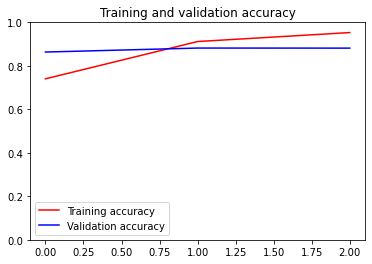

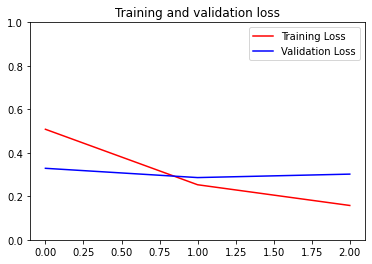

In [38]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.ylim([0,1])
plt.legend()
plt.show()

#### MODEL PREDICT

In [39]:
#remove non alphabets
comments_to_score['text'] = comments_to_score['text'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#remove punctuations
comments_to_score['text'] = comments_to_score['text'].apply(lambda x: re.sub('[<>=,\.!?:()"]', '', x))

#remove html tag (<.....>)
comments_to_score['text'] = comments_to_score['text'].apply(lambda x: re.sub('<.*?>', ' ', x))
comments_to_score['text'] = comments_to_score['text'].apply(lambda x: re.sub('br', ' ', x))

#lower case
comments_to_score['text'] = comments_to_score['text'].apply(lambda x: x.lower())

#remove stop words
comments_to_score['text'] = comments_to_score['text'].apply(lambda x : [i for i in x.split() if i not in stop_eng])

comments_to_score.head()

,comment_id,text
0,114890,"[gjalexei, asked, whether, anti, editorializin..."
1,732895,"[looks, like, abuser, please, look, thanks]"
2,1139051,"[confess, complete, apparently, blissful, igno..."
3,1434512,"[freud, ideas, certainly, much, discussed, tod..."
4,2084821,"[laundry, list, stupid, allegations, scooped, ..."


In [40]:
test_tts = token.texts_to_sequences(comments_to_score.text)
test_padded = pad_sequences(test_tts, 
                               maxlen=get_max_length(), 
                               dtype='int32', 
                               padding='post', 
                               truncating='post')

test_padded

array([[ 537,  363,  398, ..., 1446,   87,  244],
       [ 492,    5, 9410, ...,    0,    0,    0],
       [9614,  604,  844, ...,    0,    0,    0],
       ...,
       [ 219, 1040,    5, ..., 7475,    3,    6],
       [  35,  511,   20, ...,    0,    0,    0],
       [ 874,   52,  231, ...,    0,    0,    0]])

In [41]:
prediction = model.predict(test_padded)

#### SUBMISSION

In [46]:
sample_submission["score"] = prediction
sample_submission.head()

,comment_id,score
0,114890,0.019002
1,732895,0.048205
2,1139051,0.335316
3,1434512,0.045997
4,2084821,0.108496


In [43]:
sample_submission.to_csv('jigsaw_rate.csv',index=False)